In [5]:
# !pip install sklearn pandas matplotlib

In [6]:
import pandas as pd
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from utilities import *
import seaborn as sns
import matplotlib.pyplot as plt

## global vars

In [7]:
TEST_SIZE=0.2

## read the training data


In [8]:
data = pd.read_csv("train/train.csv").dropna()
print("number of features is ", data.shape)
data.head()

number of features is  (7903, 40)


,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4521252780,1,11,2,0,5,5,1,0,0,...,0,15521,6.8,18175,222,48,-544,-2063,22.2,1552.1
1,4516789805,1,17,2,0,9,4,8,1,0,...,0,15946,6.6,17106,230,52,-3538,-2904,23.0,1594.6
2,4517546735,1,85,6,1,9,1,11,1,1,...,0,13584,7.0,17661,217,42,-5240,-2335,21.7,1358.4
3,4508668617,0,17,3,0,6,4,8,0,0,...,0,15036,6.8,17006,225,40,-1954,-1045,22.5,1503.6
4,4462493939,0,16,2,0,8,9,8,0,0,...,0,18704,7.2,19776,226,52,1720,1376,22.6,1870.4


In [9]:
X,y = separate_feature_label(data, "blueWins")

In [10]:
X.shape

(7903, 39)

## preprocessing and analysis

### get the attributes with low correlation only


<AxesSubplot:>

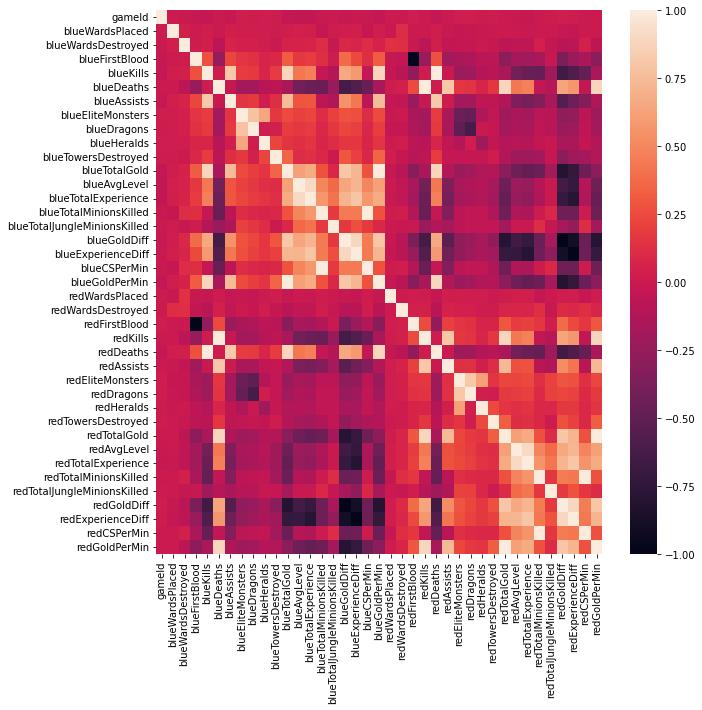

In [11]:
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr())

In [12]:
corrTable = X.corr()
cols = X.columns
corrTable

,gameId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
gameId,1.000000,0.007581,-0.013135,-0.018784,-0.037425,-0.007525,-0.021807,0.018099,0.007826,0.019485,...,0.012256,-0.004728,-0.011294,-0.018711,-0.003173,0.006975,0.017056,0.014081,-0.003173,-0.004728
blueWardsPlaced,0.007581,1.000000,0.032123,0.004943,0.023941,-0.005017,0.038240,0.028595,0.022466,0.018317,...,-0.004308,-0.006268,-0.006229,-0.012416,-0.006672,-0.007647,-0.020250,-0.031875,-0.006672,-0.006268
blueWardsDestroyed,-0.013135,0.032123,1.000000,0.012506,0.031649,-0.073581,0.064145,0.045746,0.046060,0.016814,...,-0.020540,-0.065585,-0.055534,-0.054776,0.042606,-0.030970,-0.078238,-0.076629,0.042606,-0.065585
blueFirstBlood,-0.018784,0.004943,0.012506,1.000000,0.273073,-0.242378,0.232058,0.151444,0.134443,0.077931,...,-0.066938,-0.296067,-0.184038,-0.197454,-0.161111,-0.020350,-0.377410,-0.236841,-0.161111,-0.296067
blueKills,-0.037425,0.023941,0.031649,0.273073,1.000000,0.013922,0.813396,0.179939,0.173738,0.075316,...,-0.079644,-0.154185,-0.408170,-0.457306,-0.469307,-0.211618,-0.650809,-0.578788,-0.469307,-0.154185
blueDeaths,-0.007525,-0.005017,-0.073581,-0.242378,0.013922,1.000000,-0.019324,-0.195207,-0.182452,-0.089147,...,0.160615,0.886486,0.430090,0.461086,-0.047855,-0.096700,0.637527,0.571749,-0.047855,0.886486
blueAssists,-0.021807,0.038240,0.064145,0.232058,0.813396,-0.019324,1.000000,0.151175,0.172465,0.030572,...,-0.060404,-0.129170,-0.358108,-0.394357,-0.332054,-0.163045,-0.547007,-0.433073,-0.332054,-0.129170
blueEliteMonsters,0.018099,0.028595,0.045746,0.151444,0.179939,-0.195207,0.151175,1.000000,0.783979,0.642645,...,-0.048433,-0.206448,-0.161744,-0.182974,-0.069156,-0.089088,-0.278051,-0.259519,-0.069156,-0.206448
blueDragons,0.007826,0.022466,0.046060,0.134443,0.173738,-0.182452,0.172465,0.783979,1.000000,0.028196,...,-0.029924,-0.185852,-0.141129,-0.152507,-0.055342,-0.099549,-0.234174,-0.209230,-0.055342,-0.185852
blueHeralds,0.019485,0.018317,0.016814,0.077931,0.075316,-0.089147,0.030572,0.642645,0.028196,1.000000,...,-0.041055,-0.103051,-0.086265,-0.106406,-0.043054,-0.020588,-0.158709,-0.159653,-0.043054,-0.103051


In [13]:
newCols = []
for i in cols:
    for j in cols:
        if( i!=j and abs(corrTable[i][j])<0.01 ):
            newCols.append(j)
newCols = list( pd.Series(newCols).unique() )
print( len(newCols) )
X = X[newCols]

29


In [14]:
len(cols) , len(newCols)
diff_col = [col for col in cols if col not in newCols]
print("removed the following features")
print(diff_col)
print("features reminaing")
print(newCols)

removed the following features
['blueKills', 'blueTotalGold', 'blueGoldDiff', 'blueExperienceDiff', 'blueGoldPerMin', 'redDeaths', 'redEliteMonsters', 'redDragons', 'redGoldDiff', 'redExperienceDiff']
features reminaing
['blueWardsPlaced', 'blueDeaths', 'blueDragons', 'blueTowersDestroyed', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueCSPerMin', 'redWardsPlaced', 'redWardsDestroyed', 'redKills', 'redAssists', 'redHeralds', 'redTotalGold', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redCSPerMin', 'redGoldPerMin', 'gameId', 'blueFirstBlood', 'redFirstBlood', 'redTowersDestroyed', 'redAvgLevel', 'blueWardsDestroyed', 'redTotalExperience', 'blueHeralds', 'blueAvgLevel', 'blueTotalExperience', 'blueEliteMonsters', 'blueAssists']


## remove the outliers


In [15]:
len(newCols)

29

In [16]:
X.describe()

,blueWardsPlaced,blueDeaths,blueDragons,blueTowersDestroyed,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueCSPerMin,redWardsPlaced,redWardsDestroyed,redKills,...,redFirstBlood,redTowersDestroyed,redAvgLevel,blueWardsDestroyed,redTotalExperience,blueHeralds,blueAvgLevel,blueTotalExperience,blueEliteMonsters,blueAssists
count,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,...,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000,7903.000000
mean,22.153992,6.127547,0.360369,0.050867,216.710616,50.521448,21.671062,22.477667,2.720486,6.127547,...,0.494749,0.042262,6.925117,2.830824,17957.448943,0.185879,6.913830,17922.391623,0.546248,6.652410
std,17.720187,2.931458,0.480138,0.241156,21.675143,9.850413,2.167514,18.509076,2.104507,2.931458,...,0.500004,0.214592,0.303919,2.196290,1193.670605,0.389033,0.302625,1187.832554,0.626429,4.060479
min,8.000000,0.000000,0.000000,0.000000,90.000000,0.000000,9.000000,6.000000,0.000000,0.000000,...,0.000000,0.000000,4.800000,0.000000,10465.000000,0.000000,4.800000,10826.000000,0.000000,0.000000
25%,14.000000,4.000000,0.000000,0.000000,203.000000,44.000000,20.300000,14.000000,1.000000,4.000000,...,0.000000,0.000000,6.800000,1.000000,17206.000000,0.000000,6.800000,17169.000000,0.000000,4.000000
50%,16.000000,6.000000,0.000000,0.000000,218.000000,50.000000,21.800000,16.000000,2.000000,6.000000,...,0.000000,0.000000,7.000000,3.000000,17958.000000,0.000000,7.000000,17944.000000,0.000000,6.000000
75%,20.000000,8.000000,1.000000,0.000000,232.000000,56.000000,23.200000,20.000000,4.000000,8.000000,...,1.000000,0.000000,7.200000,4.000000,18760.000000,0.000000,7.200000,18713.000000,1.000000,9.000000
max,250.000000,19.000000,1.000000,4.000000,283.000000,85.000000,28.300000,276.000000,24.000000,19.000000,...,1.000000,2.000000,8.200000,27.000000,22269.000000,1.000000,8.000000,22224.000000,2.000000,29.000000


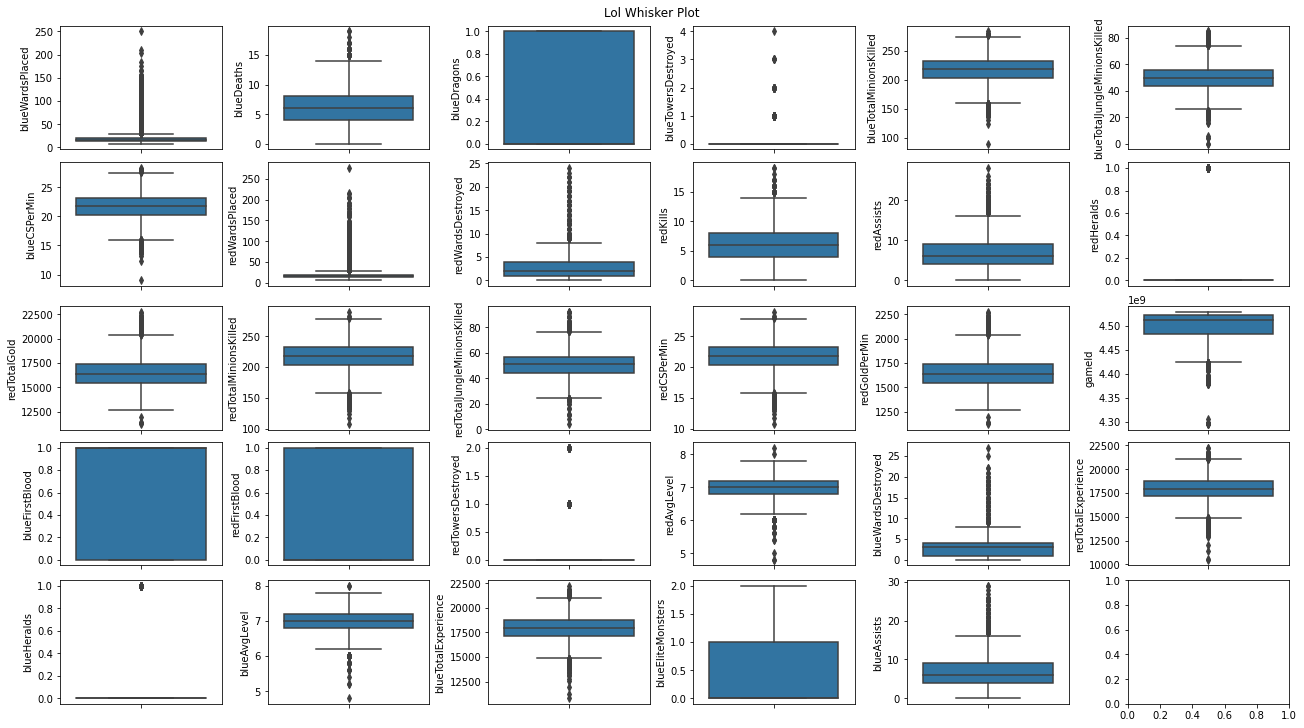

In [17]:
def whisker(data, title, colNames):

    fig, axes = plt.subplots(5, 6, figsize=(18, 10),constrained_layout=True)

    fig.suptitle(title)
    for i, col in enumerate(colNames):
        sns.boxplot(ax=axes[i//6, i - (i//6)*6], data=data, y=colNames[i])

whisker(X, 'Lol Whisker Plot', newCols)
    


In [18]:
print(newCols)

['blueWardsPlaced', 'blueDeaths', 'blueDragons', 'blueTowersDestroyed', 'blueTotalMinionsKilled', 'blueTotalJungleMinionsKilled', 'blueCSPerMin', 'redWardsPlaced', 'redWardsDestroyed', 'redKills', 'redAssists', 'redHeralds', 'redTotalGold', 'redTotalMinionsKilled', 'redTotalJungleMinionsKilled', 'redCSPerMin', 'redGoldPerMin', 'gameId', 'blueFirstBlood', 'redFirstBlood', 'redTowersDestroyed', 'redAvgLevel', 'blueWardsDestroyed', 'redTotalExperience', 'blueHeralds', 'blueAvgLevel', 'blueTotalExperience', 'blueEliteMonsters', 'blueAssists']


In [19]:
# removable_ouliers = [
#     {
#         'min':0,
#         'max':50,
#         'col':'blueWardsPlaced'
#     },
#     {
#         'min':0,
#         'max':50,
#         'col':'redWardsPlaced'
#     },{

#         'min':6,
#         'max':8,
#         'col':'redAvgLevel'
        
#     }
# ]


# for to_remove_outlier in removable_ouliers:
#     # print(X[X[to_remove_outlier['col']] > to_remove_outlier['max'] ])
#     # print(to_remove_outlier)
#     # break
#     data = data[data[to_remove_outlier['col']] <= to_remove_outlier['max'] ]
#     data = data[data[to_remove_outlier['col']] >= to_remove_outlier['min'] ]
    
# X,y = separate_feature_label(data, "blueWins")
# X = X[newCols]

# whisker(X, "removing whisker" , newCols)


### inital model


In [20]:

treeClassifier = tree.DecisionTreeClassifier(
    min_samples_leaf=100, max_depth=10
)
original_X_train, original_X_test, original_y_train, original_y_test =train_test_split( X, y, test_size=TEST_SIZE, random_state=42)


### parameter tuning and validation


In [21]:
parameters = {'max_depth':[10,11,12,20], 
              'min_samples_leaf':[50,100,150], 
              'min_samples_split':[10,50,100,150,200,250],
              'criterion' : ['gini','entropy']}
scorer = make_scorer(f1_score)

search_obj = RandomizedSearchCV(treeClassifier, parameters, scoring=scorer)
fit_obj = search_obj.fit(original_X_train, original_y_train)
best_clf = fit_obj.best_estimator_

print( "Validation Accuracy for tree classifier: "+str( metrics.accuracy_score(original_y_test, best_clf.predict(original_X_test)) ) )


Validation Accuracy for tree classifier: 0.7115749525616698


In [22]:
print("best parameters is ", fit_obj.best_params_)


best parameters is  {'min_samples_split': 200, 'min_samples_leaf': 100, 'max_depth': 20, 'criterion': 'entropy'}


## final classifier

In [23]:
treeClassifier = best_clf

[Text(0.4554794520547945, 0.9444444444444444, 'redGoldPerMin <= 1576.85\nentropy = 1.0\nsamples = 6322\nvalue = [3161, 3161]\nclass = lose'),
 Text(0.1952054794520548, 0.8333333333333334, 'blueTotalExperience <= 18651.5\nentropy = 0.822\nsamples = 2086\nvalue = [536, 1550]\nclass = win'),
 Text(0.1095890410958904, 0.7222222222222222, 'redTotalExperience <= 16909.0\nentropy = 0.926\nsamples = 1167\nvalue = [398, 769]\nclass = win'),
 Text(0.0547945205479452, 0.6111111111111112, 'blueTotalExperience <= 17813.5\nentropy = 0.754\nsamples = 434\nvalue = [94, 340]\nclass = win'),
 Text(0.0273972602739726, 0.5, 'redTotalGold <= 14913.5\nentropy = 0.906\nsamples = 202\nvalue = [65, 137]\nclass = win'),
 Text(0.0136986301369863, 0.3888888888888889, 'entropy = 0.778\nsamples = 100\nvalue = [23, 77]\nclass = win'),
 Text(0.0410958904109589, 0.3888888888888889, 'entropy = 0.977\nsamples = 102\nvalue = [42, 60]\nclass = win'),
 Text(0.0821917808219178, 0.5, 'blueDragons <= 0.5\nentropy = 0.544\nsam

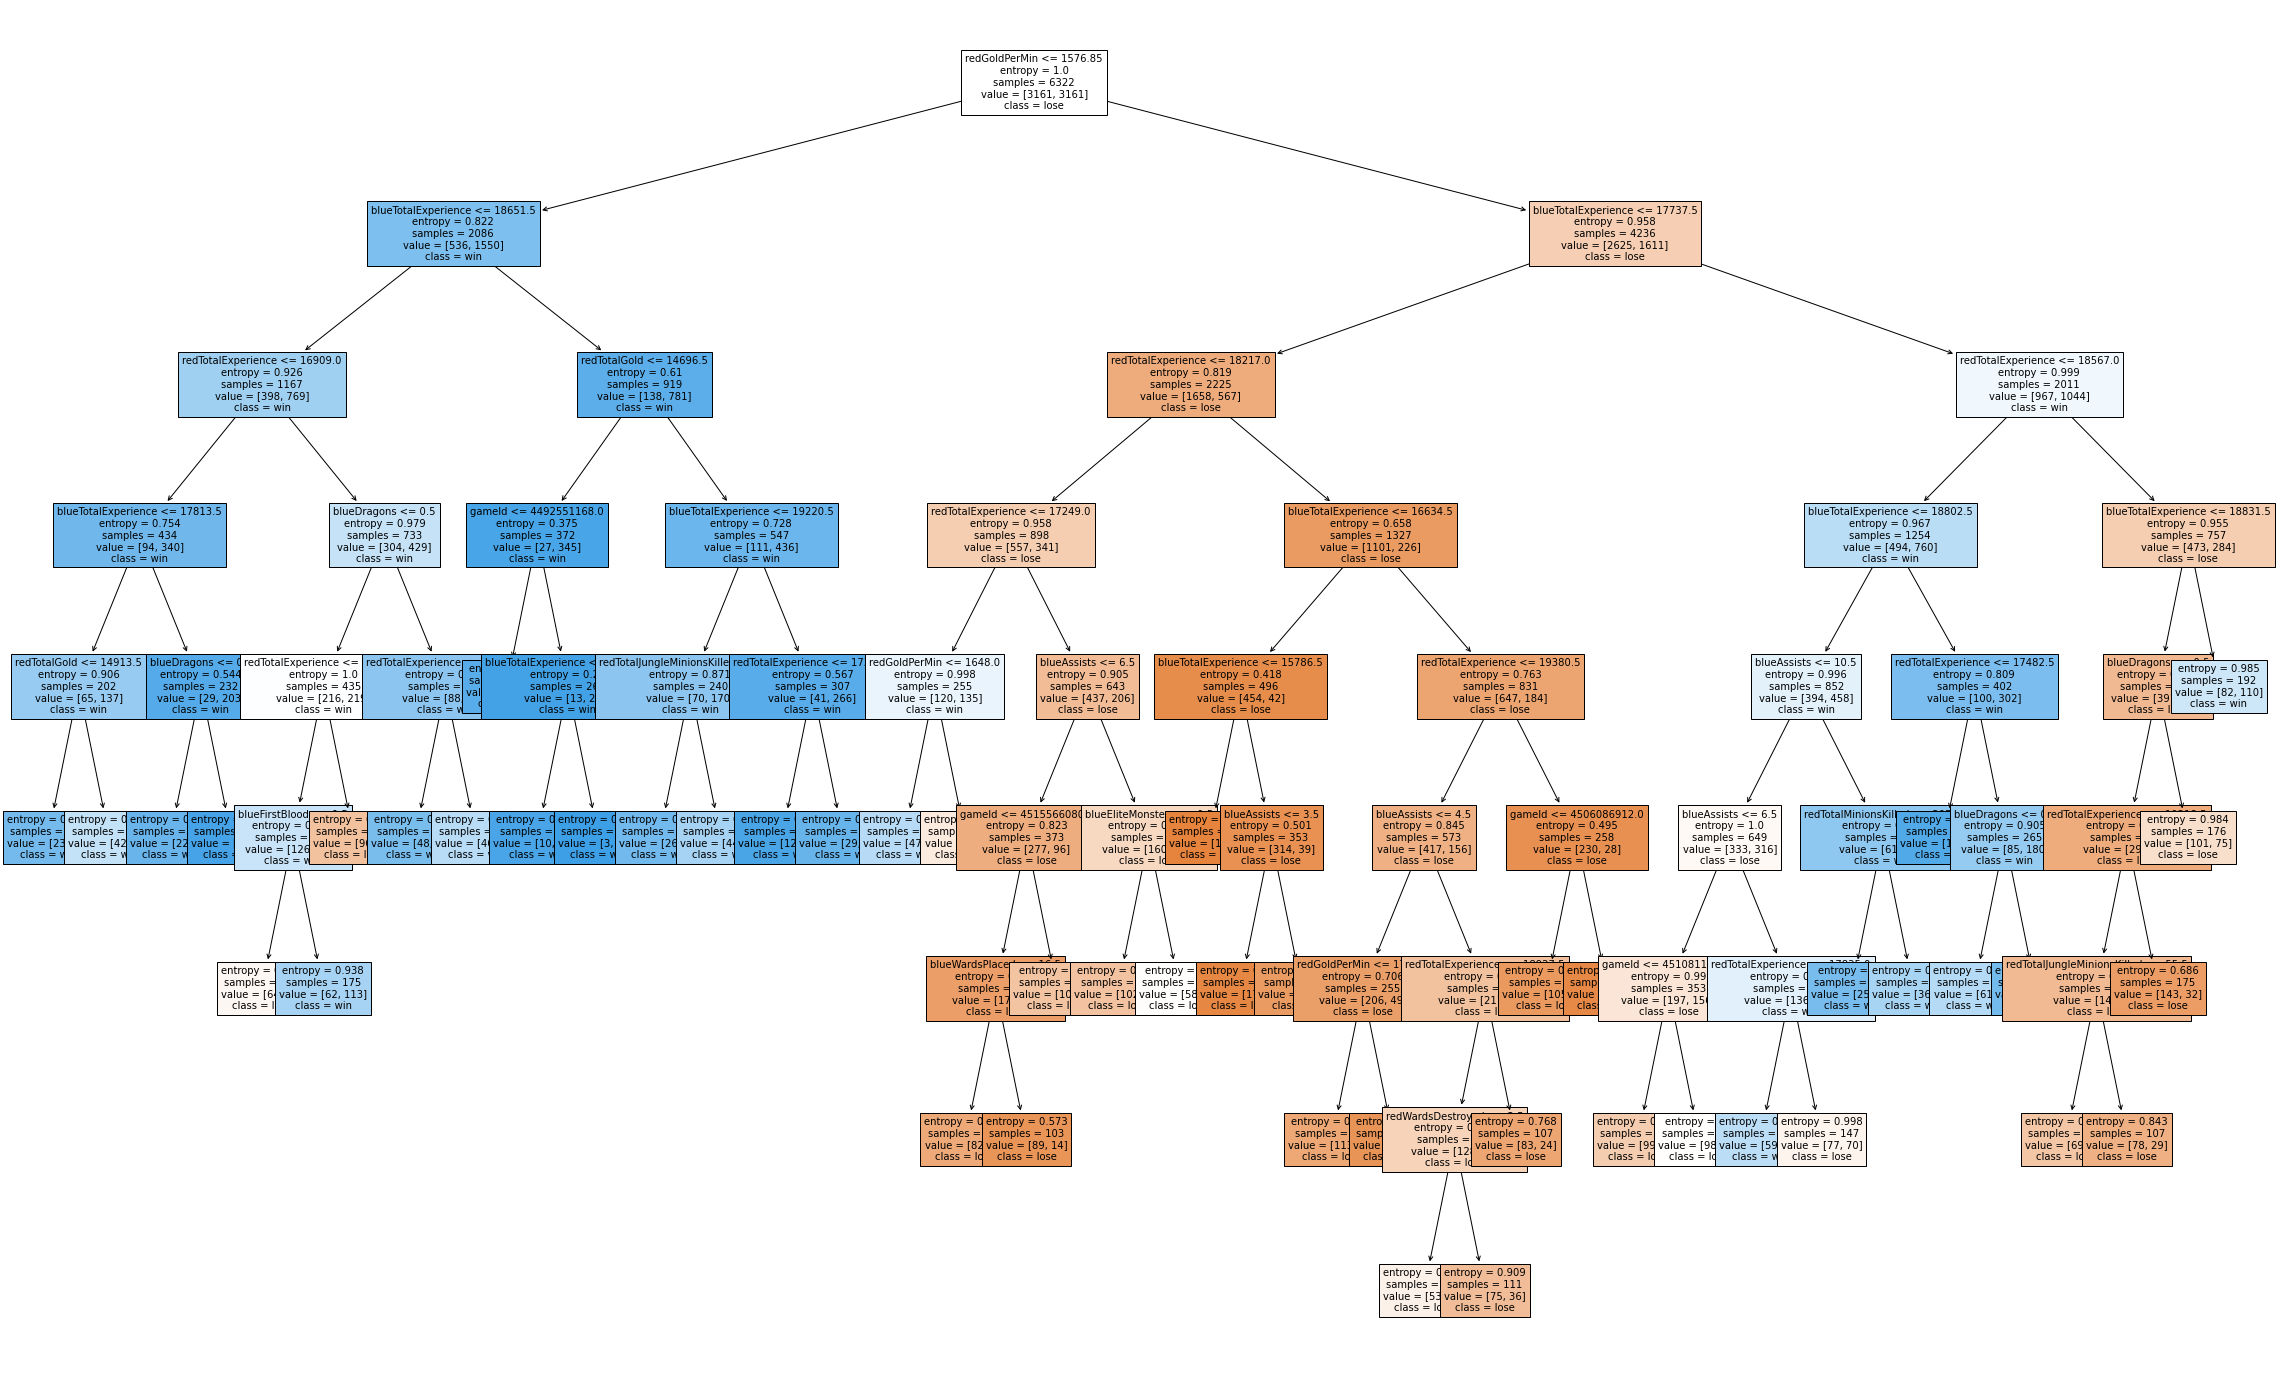

In [24]:
fig = plt.figure(figsize=(40,25))

tree.plot_tree(treeClassifier, class_names=["lose", "win"],feature_names=newCols,filled=True,fontsize=10)


## DecisionTree model testing on unseen data

In [25]:

test_data = pd.read_csv("test/test.csv").dropna()


X_test,y_test = separate_feature_label(test_data, "blueWins")
X_test = X_test[newCols]

print( "Test Accuracy for tree classifier: "+str( metrics.accuracy_score(y_test, treeClassifier.predict(X_test)) ) )


Test Accuracy for tree classifier: 0.7130566801619433


# Normalizing data

In [26]:
from sklearn.metrics import accuracy_score
# fit logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [27]:
scaler = MinMaxScaler()
scaler.fit(original_X_train)
original_X_train_normalized = scaler.transform(original_X_train)
original_X_test_normalized = scaler.transform(original_X_test)


# Logistic Regression

## building the model

In [28]:

logisticRegressor = LogisticRegression()
logisticRegressor.fit(original_X_train_normalized, original_y_train)


# get accuracy score
pred_lm = logisticRegressor.predict(original_X_test_normalized)
acc_lm = accuracy_score(pred_lm, original_y_test)
print(acc_lm)

0.7273877292852625


In [46]:
logisticRegressor = LogisticRegression()
#  added random to the parameters to see w
parameters = {
        'C':[2.0,1.0,.1,.02, .01], # C is the inverse of Lambda
        'penalty':[ "l2"]
            }
scorer = make_scorer(f1_score)

search_obj = GridSearchCV(logisticRegressor, parameters, scoring=scorer)
fit_obj = search_obj.fit(original_X_train_normalized, original_y_train)
best_clf = fit_obj.best_estimator_

/home/mohammed/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(original_y_test, best_clf.predict(original_X_test_normalized)) ) )


Accuracy for tree classifier: 0.7273877292852625


In [49]:
print("best parameters is ", fit_obj.best_params_)


best parameters is  {'C': 1.0, 'penalty': 'l2'}


## LogisticRegression model testing on unseen data

In [29]:

test_data = pd.read_csv("test/test.csv").dropna()


X_test,y_test = separate_feature_label(test_data, "blueWins")
X_test = X_test[newCols]
X_test = scaler.transform(X_test)

print( "Test Accuracy for LogisticRegression classifier: "+str( metrics.accuracy_score(y_test, logisticRegressor.predict(X_test)) ) )


Test Accuracy for LogisticRegression classifier: 0.7338056680161943


# Adaboost Classifier

In [30]:
from sklearn.ensemble import AdaBoostClassifier

## Model tuning

In [31]:
print(len(newCols))

29


In [32]:
ababooster = AdaBoostClassifier(n_estimators=100, random_state=42)

ababooster.fit(original_X_train_normalized, original_y_train)

# get accuracy score
pred_lm = ababooster.predict(X_test)
acc_lm = accuracy_score(pred_lm, y_test)
print(acc_lm)

0.7272267206477733


In [33]:
ababooster = AdaBoostClassifier(n_estimators=100, random_state=42)

parameters = {
        'n_estimators':[90,100,150],
        'base_estimator':[tree.DecisionTreeClassifier( max_depth=1),tree.DecisionTreeClassifier( max_depth=2)]
            }
scorer = make_scorer(f1_score)

search_obj = RandomizedSearchCV(ababooster, parameters, scoring=scorer)
fit_obj = search_obj.fit(original_X_train_normalized, original_y_train)
best_clf = fit_obj.best_estimator_


/home/mohammed/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [34]:
print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(original_y_test, best_clf.predict(original_X_test_normalized)) ) )


Accuracy for tree classifier: 0.7115749525616698


In [35]:
print("best parameters is ", fit_obj.best_params_)


best parameters is  {'n_estimators': 90, 'base_estimator': DecisionTreeClassifier(max_depth=1)}


In [36]:
ababooster=best_clf

In [37]:

test_data = pd.read_csv("test/test.csv").dropna()

X_test,y_test = separate_feature_label(test_data, "blueWins")
X_test = X_test[newCols]
X_test = scaler.transform(X_test)

print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(y_test, ababooster.predict(X_test)) ) )


Accuracy for tree classifier: 0.728744939271255


# SVM 

## Model Training and Tuning

In [38]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
svmer = svm.SVC(kernel='linear') # Linear Kernel

parameters = {
        'kernel':["linear","poly"],
        "C":[2.0, 1.0 , .75 ,.5, .25 , .01, .001]
            }
scorer = make_scorer(f1_score)

search_obj = RandomizedSearchCV(svmer, parameters, scoring=scorer)
fit_obj = search_obj.fit(original_X_train_normalized, original_y_train)
best_clf = fit_obj.best_estimator_

#Train the model using the training sets
# svmer.fit(X_train, y_train)

#Predict the response for test dataset

svmer=best_clf

In [39]:
pred_lm = best_clf.predict(original_X_test_normalized)
acc_lm = accuracy_score(pred_lm, original_y_test)
print(acc_lm)

0.726122707147375


In [40]:
print("best parameters is ", fit_obj.best_params_)


best parameters is  {'kernel': 'linear', 'C': 0.25}


## Model Testing

In [41]:
#Import scikit-learn metrics module for accuracy calculation

test_data = pd.read_csv("test/test.csv").dropna()


X_test,y_test = separate_feature_label(test_data, "blueWins")
X_test = X_test[newCols]
X_test = scaler.transform(X_test)

print( "Test Accuracy for svm classifier: "+str( metrics.accuracy_score(y_test, svmer.predict(X_test)) ) )



Test Accuracy for svm classifier: 0.7322874493927125
